**Математические основы машинного обучения II**
*Домашнее задание №3. Визуализация и Кластеризация*
**Выполнила Савоськиной С.В.**

# 1. Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn import preprocessing as prep

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import  KernelPCA
from sklearn.cluster import AgglomerativeClustering

# 2. Настройка параметров

In [2]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision",6)
pd.set_option("plotting.backend", "matplotlib")
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')

#Для корректного отображения графиков в ноутбуках используется команда %matplotlib inline
%matplotlib inline
# для корректного отображения графиков на тёмном фоне
plt.style.use('default')

sns.set_style("whitegrid")
sns.set_palette('coolwarm')
sns.set(rc={'figure.figsize':(20, 5)})

# 3. Код (вспомогательные методы)

In [3]:
RANDOM_STATE = 18
LOCAL_FOLDER = './data/'
TEST_SIZE = 0.3

# Столбцы, содержащие категориальные признаки
CAT_FEATURES=['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
              'Utilities', 'LotConfig',  'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
              'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
              'Exterior1st',  'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
              'BsmtQual', 'BsmtCond', 'BsmtExposure',  'BsmtFinType1',  'BsmtFinType2',
              'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
              'FireplaceQu', 'GarageType', 'GarageQual', 'GarageCond', 'GarageFinish',
              'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

# Столбцы, содержащие числовые признаки
NUM_FEATURES=['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
               'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
               'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
                'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
               'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
               'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',  'SalePrice']

# Столбцы, содержащие порядковые числовые признаки. Они содержат количество, но в ряде случае с ними удобнее работать 
# как с категориальными
ORD_FEATURES =['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
  'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

# Целевой признак для регрессии
TARGET_FEATURE = 'Age'

def show_dataset_info(dataset):
    """
    Вывод основной информации о датасете
    :param dataset: Датасет для обработки
    :return: None
    """
    print(
    f"Размер набора данных: {dataset.shape}",
    f"Дупликатов: {dataset.duplicated().sum()}",
    f"Всего пропусков: {dataset.isna().sum().sum()}",
    f"Пропусков в столбцах: {dataset.loc[:,dataset.isna().sum()>0].isna().sum().sort_values()}",
    sep="\n"
)


def show_column_types(dataset):
    """
    Вывод числовых и категориальных столбцов в датасете
    :param dataset: Датасет для обработки
    :return: кортеж: список категориальных столбцов, список числовых столбцов
    """
    nums_df = dataset[NUM_FEATURES]
    cats_df = dataset[CAT_FEATURES]

    # выводим результат
    print('Категориальные признаки:\t ',cats_df.columns, '\n Число столбцов = ',len(cats_df.columns))
    print('Числовые признаки:\t ',  nums_df.columns, '\n Число столбцов = ',len(nums_df.columns))

    return cats_df.columns, nums_df.columns


def drop_feature(dataset, columns_to_drop, cat_columns, num_columns):
    """
    Удаление признаков (столбцов) из датасета
    :param dataset: Датасет для обработки
    :param columns_to_drop:  Столбцы для удаления
    :param cat_columns: Список категориальных столбцов
    :param num_columns: Список числовых столбцов
    :return: кортеж: новый список категориальных столбцов, новый список числовых столбцов
    """
    for col in columns_to_drop:
        print(f"Удаляется признак {col}")
        dataset.drop(col, axis=1, inplace=True, errors ="ignore")
        if cat_columns is not None:
            cat_columns = cat_columns.drop(col, errors ="ignore")
        if num_columns is not None:
            num_columns = num_columns.drop(col, errors ="ignore")

    return cat_columns, num_columns


def drop_corr_features(dataset, num_columns):
    """
    Удаление коррелирующих признаков
    :param dataset: Датасет для обработки
    :param num_columns: Числовые столбцы для обработки
    :return: кортеж: обработанный датасет, новый список числовых столбцов
    """
    correlations = dataset[num_columns].corr()
    dropped=[]

    for row_idx, row in enumerate(correlations.index):
        for col_idx in range(row_idx+1, len(correlations.index)):
            if (row_idx !=col_idx and row_idx not in dropped and col_idx not in dropped
                    and abs(correlations.iloc[row_idx, col_idx])>0.75):
                print(f"Признак {row} с признаком {correlations.columns[col_idx]} имеет коэффициент корреляции",
                   correlations.iloc[row_idx, col_idx])

                col_to_drop=[correlations.columns[col_idx]]
                dropped.append(col_idx)

                _, num_columns = drop_feature(dataset, col_to_drop, None, num_columns)

    return dataset, num_columns


def show_hist(dataset, columns, log_columns):
    """
    Показ гистограмм для нескольких столбцов
    :param dataset: Датасет для обработки
    :param columns: Столбцы для обработки
    :param log_columns: столбцы, для которых необходимо выполнить логарифмирование
    :return: None
    """
    _cols = 4
    _rows = int(np.ceil(len(columns) / _cols))

    fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(12, 12), gridspec_kw={'wspace':0.2,'hspace':0.5 })
    ax = ax.flatten()

    for idx, column_name in enumerate(columns):
        if column_name not in ORD_FEATURES:
            hplot = sns.histplot(dataset, x= dataset[column_name], ax=ax[idx] ,
                                 log_scale = column_name in log_columns, bins=16, color='lime')
            hplot.grid()

def show_scatter(dataset, columns):
    """
    Показ гистограмм для нескольких столбцов
    :param dataset: Датасет для обработки
    :param columns: Столбцы для обработки
    :return: None
    """
    _cols = 4
    _rows = int(np.ceil(len(columns) / _cols))

    fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(20, 20), gridspec_kw={'wspace':0.2,'hspace':0.7 })
    ax = ax.flatten()

    for idx, column_name in enumerate(columns):
        plot_data=sns.scatterplot(data=dataset,
                                  x=TARGET_FEATURE,
                                  y=column_name,
                                  palette="YlGnBu",
                                  ax=ax[idx]);

        # plot_data.set_title(f'Распределение {column_name} в зависимости от цены');
        plot_data.set_xlabel('Цена');
        plot_data.set_ylabel(column_name);
        plot_data.grid()

def search_outliers(feature):
    """
    Поиск выбросов в столбце
    :param feature: Столбец для обработки
    :return: количество выбросов в столбце
    """
    q1, q3 = np.percentile(feature, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return np.where((feature < lower_bound) | (feature > upper_bound))[0]


def show_outliers(dataset, columns):
    """
    Вывод количества выбросов по столбцам
    :param dataset: Датасет для обработки
    :param columns: Столбцы для обработки
    :return: None
    """
    for col in columns:
        outliers=search_outliers(dataset[col])
        sum_outliers = len(outliers)
        print(f"Признак {col} содержит {sum_outliers} выбросов из {dataset[col].shape[0]} наблюдений ({sum_outliers/dataset[col].shape[0]*100:.2f}%)")


def drop_outliers(dataset, columns):
    """
    Удаление выбросов
    :param dataset: Датасет для обработки
    :param columns: Столбцы для обработки
    :return: Датасет с удаленными выбросами
    """

    for col in columns:
        q1, q3 = np.percentile(dataset[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        sub_dataset=dataset[(dataset[col] < lower_bound) | (dataset[col] > upper_bound)]
        dataset = dataset.drop(sub_dataset.index)

    dataset = dataset.reset_index(drop=True)
    return dataset


def classification_metrics(pipeline, X_test, y_test):
    """
    Вывод метрик
    :param pipeline: обученный пайплайн обработки
    :param X_test: тестовая выборка
    :param y_test: значения целевой переменной для тестовой выборки
    :return: None
    """
    y_pred = pipeline.predict(X_test)
    avg = "micro"
    print("f1_score: ", f1_score(y_test, y_pred, average=avg))
    print("accuracy: ", accuracy_score(y_test, y_pred))
    print("precision: ", precision_score(y_test, y_pred, average=avg))
    print("recall: ", recall_score(y_test, y_pred, average=avg))
    confusion_matrix(y_test, y_pred)


# 4. Загрузка и подготовка данных
## 4.1. Загрузка данных

Загружаем датасет из https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [4]:
datafile = LOCAL_FOLDER + 'train.csv'
df = pd.read_csv(datafile, sep=',', index_col='Id',  low_memory=False)

df.sample(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
670           30       RL         80.0    11600   Pave   NaN      Reg   
1196          60       RL         51.0     8029   Pave   NaN      IR1   
458           20       RL          NaN    53227   Pave   NaN      IR1   
418           70       RL         86.0    22420   Pave   NaN      IR1   
869           60       RL          NaN    14762   Pave   NaN      IR2   

     LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                    ...                                     
670          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1196         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
458          Low    AllPub   CulDSac  ...        0    NaN   NaN         NaN   
418          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
869          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                               
670        0      7    2006        WD         Normal     137500  
1196       0      7    2008        WD         Normal     176000  
458        0      3    2008        WD         Normal     256000  
418        0     11    2007        WD         Normal     239000  
869        0      5    2006        WD         Normal     169000  

[5 rows x 80 columns]

## 4.2. Информация о DataFrame

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [6]:
show_dataset_info(df)

Размер набора данных: (1460, 80)
Дупликатов: 0
Всего пропусков: 7829
Пропусков в столбцах: Electrical         1
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageYrBlt       81
GarageType        81
LotFrontage      259
FireplaceQu      690
MasVnrType       872
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64


In [7]:
df.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315  ...   
std      30.202904     20.645407   181.066207   456.098091   161.319273  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000  ...   
50%    1973.000000   1994.000000     0.000000   383.500000     0.000000  ...   
75%    2000.000000   2004.000000   166.000000   712.250000     0.000000  ...   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 37 columns]

In [8]:
df.describe(include=['object','datetime64[ns]', 'category'])

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460    91     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454    50      925        1311      1459      1052   

       LandSlope Neighborhood Condition1  ... GarageType GarageFinish  \
count       1460         1460       1460  ...       1379         1379   
unique         3           25          9  ...          6            3   
top          Gtl        NAmes       Norm  ...     Attchd          Unf   
freq        1382          225       1260  ...        870          605   

       GarageQual GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType  \
count        1379       1379       1460      7    281          54     1460   
unique          5          5          3      3      4           4        9   
top            TA         TA          Y     Gd  MnPrv        Shed       WD   
freq         1311       1326       1340      3    157          49     1267   

       SaleCondition  
count           1460  
unique             6  
top           Normal  
freq            1198  

[4 rows x 43 columns]

In [9]:
cat_columns, num_columns = show_column_types(df)

#Убираем столбцы с порядковыми данными
not_ord_columns = num_columns.drop(ORD_FEATURES, errors ="ignore")

Категориальные признаки:	  Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageQual', 'GarageCond', 'GarageFinish', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object') 
 Число столбцов =  46
Числовые признаки:	  Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'Bsmt

В датасете 1460 строки, 80 столбцов, часть из них текстовые, часть числовые. Большая часть столбцов, как числовых, так и строковых, содержат категориальные данные (это известно из описания датасета, не приведенного здесь). Категориальных столбцов - 46, числовых - 33.
Целевой столбец - SalePrice - цена продажи дома. Цена продажи дома варьируется от 34900 до 755000, средняя цена 180900, что немного выше медианного значения 163000, что говорит о небольшом преобладании домов с более низкой ценой.
Много пропусков в разных столбцах. Особенно много в столбцах LotFrontage (259), FireplaceQu (690), MasVnrType (872),
Fence (1179), Alley (1369), MiscFeature (1406), PoolQC (1453). Они будут удалены.
Дупликатов нет.

## 4.3. Предобработка данных

Удалим признаки для которых слишком много пропусков

In [10]:
columns_to_drop=df.columns[df.isna().sum()>400]
cat_columns, num_columns = drop_feature(df, columns_to_drop,cat_columns,num_columns)

show_dataset_info(df)

Удаляется признак Alley
Удаляется признак MasVnrType
Удаляется признак FireplaceQu
Удаляется признак PoolQC
Удаляется признак Fence
Удаляется признак MiscFeature
Размер набора данных: (1460, 74)
Дупликатов: 0
Всего пропусков: 860
Пропусков в столбцах: Electrical        1
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
BsmtExposure     38
BsmtFinType2     38
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
LotFrontage     259
dtype: int64


Датасет содержит очень много признаков. Оценим их влияние через вариативность. Оставим только те
признаки, у которых скопление значений по отдельным категориям не превышает порога в 0.8.

In [11]:
for cat_col in df.columns:
    total_count = df[cat_col].count()
    most_count = df[cat_col].value_counts().sort_values(ascending=False).iloc[0]
    var_coef = most_count / total_count
    if var_coef > 0.8:
        print(f'Найдено превалирующее значение {most_count} в столбце {cat_col}')
        cat_columns, num_columns = drop_feature(df, [cat_col], cat_columns,num_columns)

Найдено превалирующее значение 1454 в столбце Street
Удаляется признак Street
Найдено превалирующее значение 1311 в столбце LandContour
Удаляется признак LandContour
Найдено превалирующее значение 1459 в столбце Utilities
Удаляется признак Utilities
Найдено превалирующее значение 1382 в столбце LandSlope
Удаляется признак LandSlope
Найдено превалирующее значение 1260 в столбце Condition1
Удаляется признак Condition1
Найдено превалирующее значение 1445 в столбце Condition2
Удаляется признак Condition2
Найдено превалирующее значение 1220 в столбце BldgType
Удаляется признак BldgType
Найдено превалирующее значение 1434 в столбце RoofMatl
Удаляется признак RoofMatl
Найдено превалирующее значение 1282 в столбце ExterCond
Удаляется признак ExterCond
Найдено превалирующее значение 1311 в столбце BsmtCond
Удаляется признак BsmtCond
Найдено превалирующее значение 1256 в столбце BsmtFinType2
Удаляется признак BsmtFinType2
Найдено превалирующее значение 1293 в столбце BsmtFinSF2
Удаляется признак

Удалим числовые признаки, которые сильно коррелируют друг с другом

In [12]:
df,num_columns= drop_corr_features(df,num_columns)

Признак YearBuilt с признаком GarageYrBlt имеет коэффициент корреляции 0.8256674841743408
Удаляется признак GarageYrBlt
Признак TotalBsmtSF с признаком 1stFlrSF имеет коэффициент корреляции 0.8195299750050339
Удаляется признак 1stFlrSF
Признак GrLivArea с признаком TotRmsAbvGrd имеет коэффициент корреляции 0.8254893743088425
Удаляется признак TotRmsAbvGrd
Признак GarageCars с признаком GarageArea имеет коэффициент корреляции 0.882475414281462
Удаляется признак GarageArea


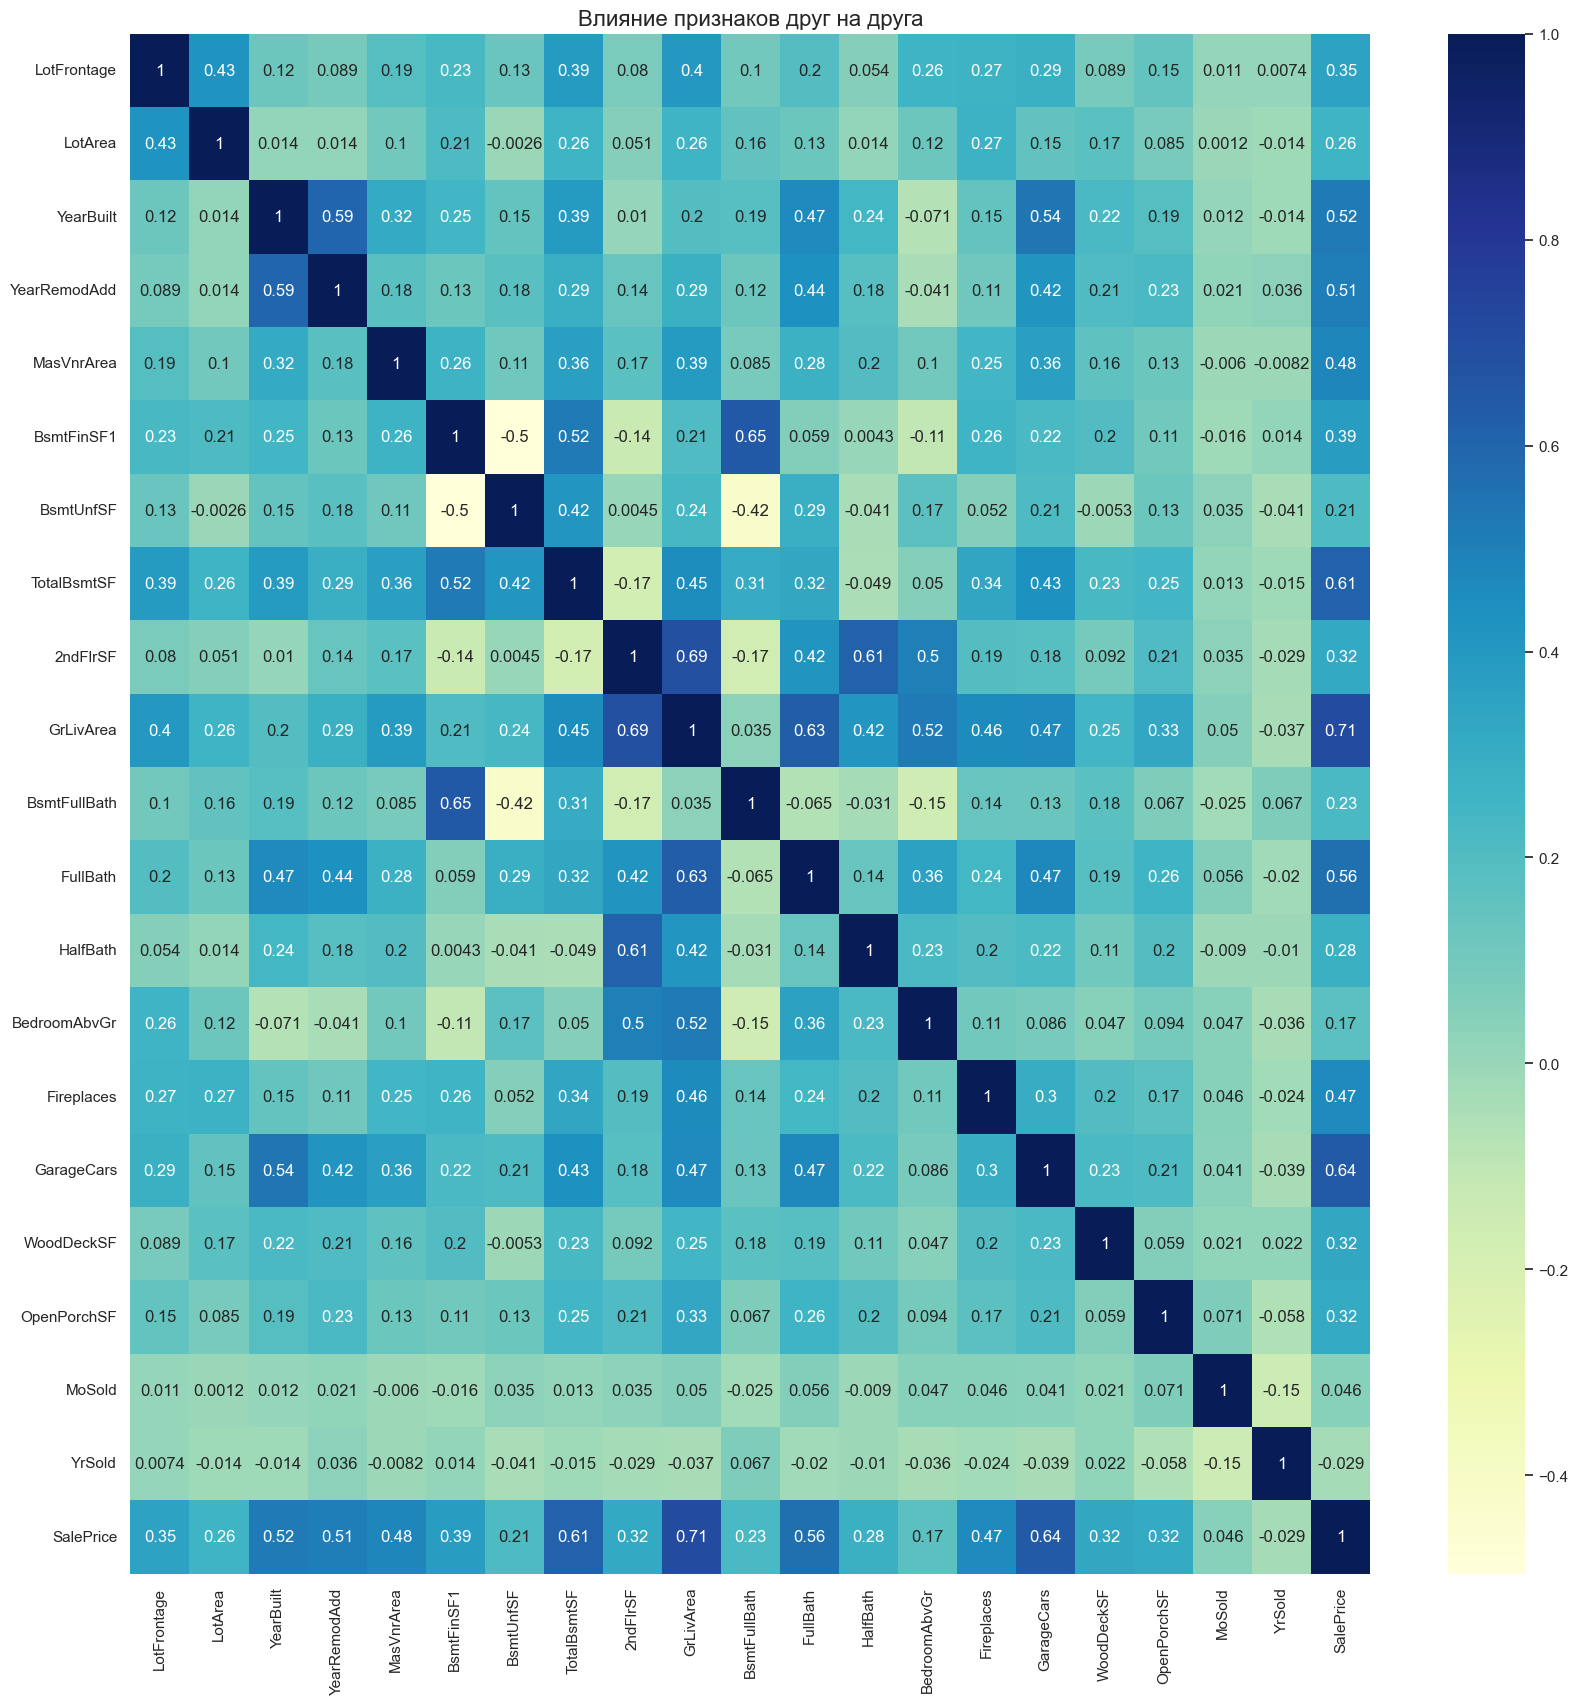

In [13]:
fig = plt.figure(figsize=(20, 20))
plot_data = sns.heatmap(df[num_columns].corr(), cmap="YlGnBu", annot=True);
plot_data.set_title('Влияние признаков друг на друга', fontsize=16);

Оценим выбросы

Диаграмма размаха


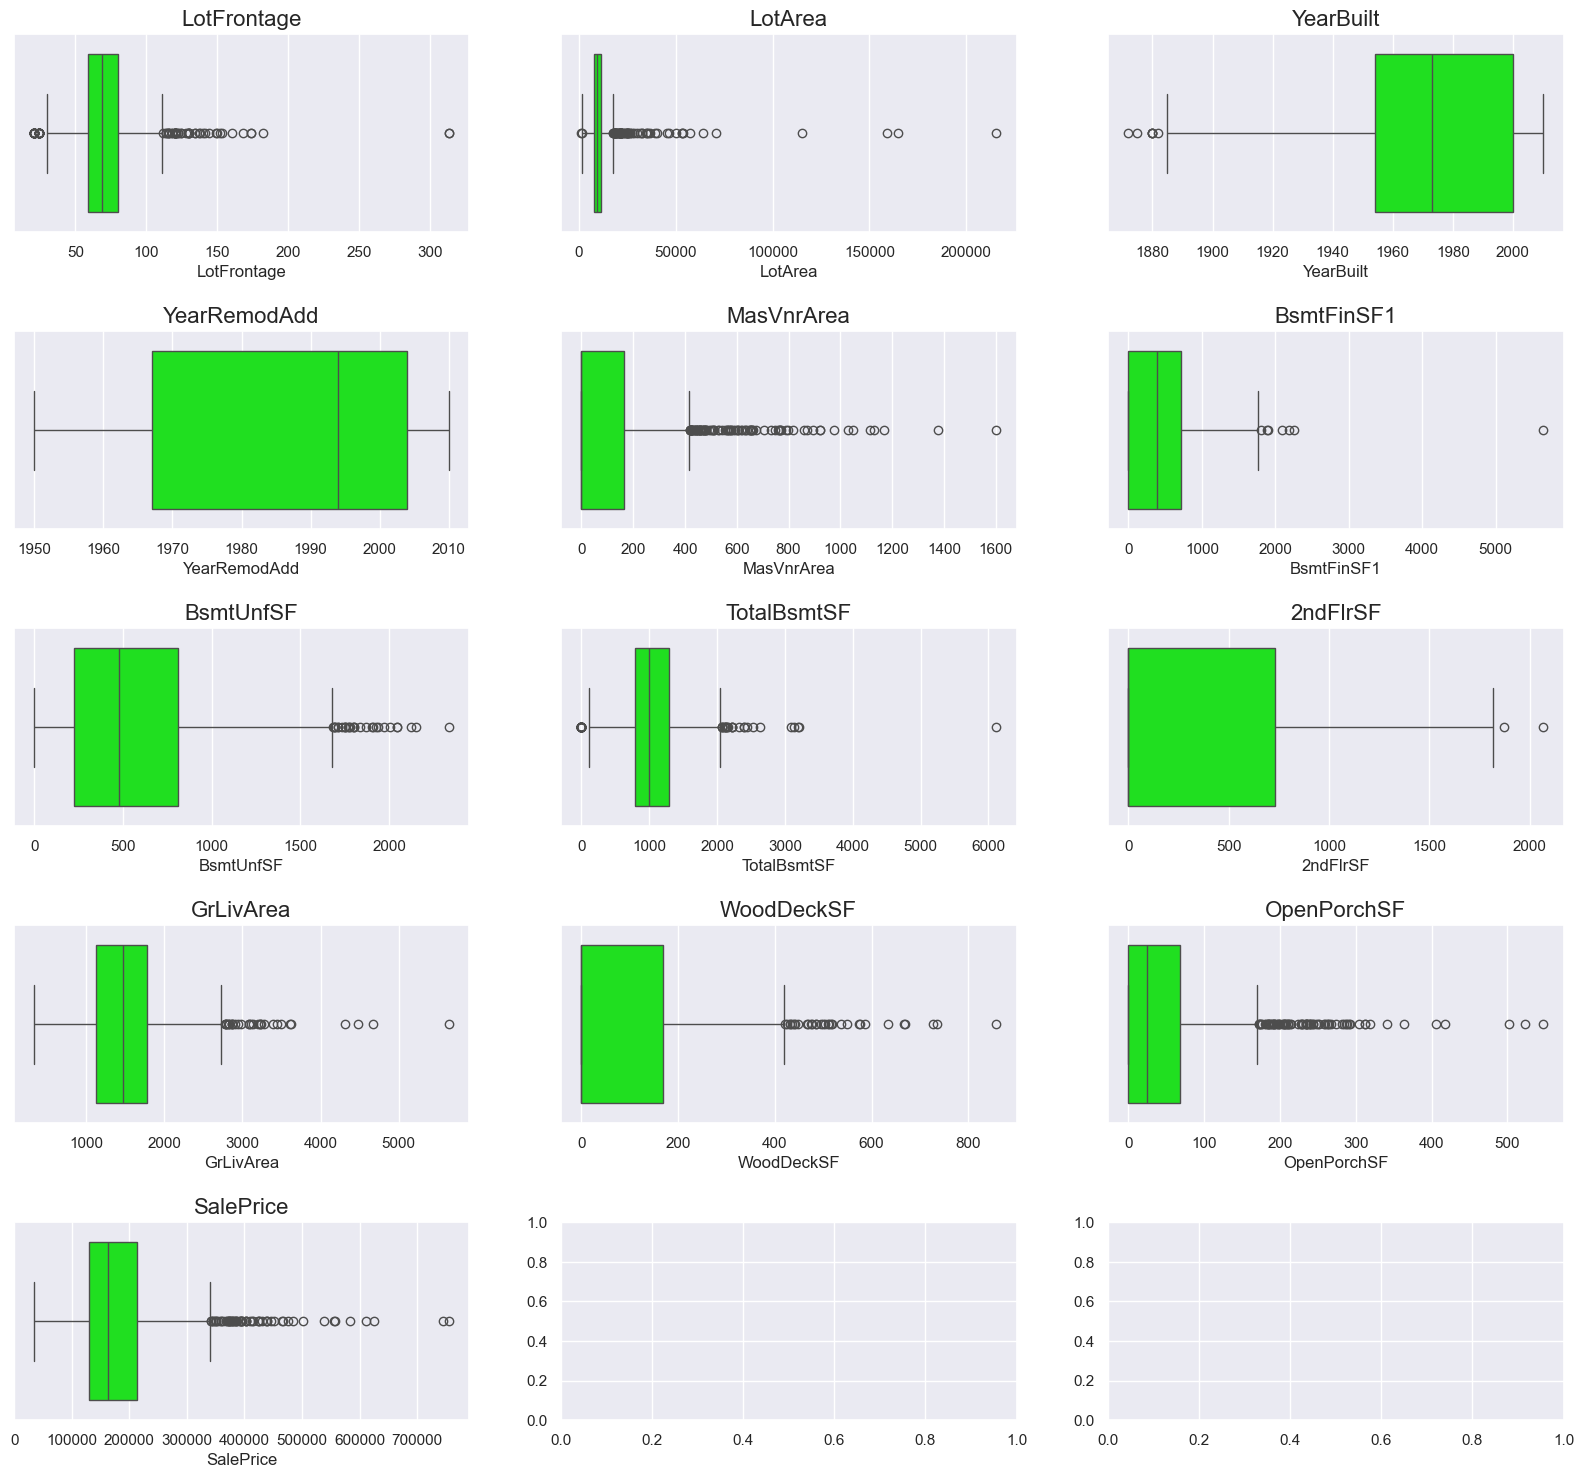

In [14]:
not_ord_columns = num_columns.drop(ORD_FEATURES, errors ="ignore")

num=-1
rows=int(np.ceil(len(not_ord_columns)/3))
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(20, 18), gridspec_kw={'wspace':0.2,'hspace':0.5 })
plt.subplots_adjust(hspace=.3)
print("Диаграмма размаха")

for feature in not_ord_columns:
    num = num+1
    x=num//3
    y=num -3*x
    sns.boxplot(data=df, x=feature, orient='h', color='lime', ax=axes[x,y]).set_title(feature, fontsize=16)

Выбросы есть, у большинства признаков в верхнем диапазоне значений, что видимо связано с отдельными особо крупными
объектами недвижимости. Поскольку таких объектов в выборке мало для получения по ним адекватной статистики,
 их лучше удалить. Посмотрим количество выбросов по каждому признаку

In [15]:
show_outliers(df,not_ord_columns)

Признак LotFrontage содержит 0 выбросов из 1460 наблюдений (0.00%)
Признак LotArea содержит 69 выбросов из 1460 наблюдений (4.73%)
Признак YearBuilt содержит 7 выбросов из 1460 наблюдений (0.48%)
Признак YearRemodAdd содержит 0 выбросов из 1460 наблюдений (0.00%)
Признак MasVnrArea содержит 0 выбросов из 1460 наблюдений (0.00%)
Признак BsmtFinSF1 содержит 7 выбросов из 1460 наблюдений (0.48%)
Признак BsmtUnfSF содержит 29 выбросов из 1460 наблюдений (1.99%)
Признак TotalBsmtSF содержит 61 выбросов из 1460 наблюдений (4.18%)
Признак 2ndFlrSF содержит 2 выбросов из 1460 наблюдений (0.14%)
Признак GrLivArea содержит 31 выбросов из 1460 наблюдений (2.12%)
Признак WoodDeckSF содержит 32 выбросов из 1460 наблюдений (2.19%)
Признак OpenPorchSF содержит 77 выбросов из 1460 наблюдений (5.27%)
Признак SalePrice содержит 61 выбросов из 1460 наблюдений (4.18%)


Попробуем почистить.

In [16]:
df=drop_outliers(df, not_ord_columns)
show_outliers(df,not_ord_columns)

Признак LotFrontage содержит 0 выбросов из 1126 наблюдений (0.00%)
Признак LotArea содержит 35 выбросов из 1126 наблюдений (3.11%)
Признак YearBuilt содержит 0 выбросов из 1126 наблюдений (0.00%)
Признак YearRemodAdd содержит 0 выбросов из 1126 наблюдений (0.00%)
Признак MasVnrArea содержит 0 выбросов из 1126 наблюдений (0.00%)
Признак BsmtFinSF1 содержит 0 выбросов из 1126 наблюдений (0.00%)
Признак BsmtUnfSF содержит 4 выбросов из 1126 наблюдений (0.36%)
Признак TotalBsmtSF содержит 5 выбросов из 1126 наблюдений (0.44%)
Признак 2ndFlrSF содержит 0 выбросов из 1126 наблюдений (0.00%)
Признак GrLivArea содержит 9 выбросов из 1126 наблюдений (0.80%)
Признак WoodDeckSF содержит 13 выбросов из 1126 наблюдений (1.15%)
Признак OpenPorchSF содержит 41 выбросов из 1126 наблюдений (3.64%)
Признак SalePrice содержит 16 выбросов из 1126 наблюдений (1.42%)


Количество выбросов значительно уменьшилось. Дальнейшая чистка может привести к значительной потере объема выборки,
поэтому полученные результаты считаем приемлимыми.

Посмотрим на гистограммы числовых признаков, не являющиеся порядковыми.

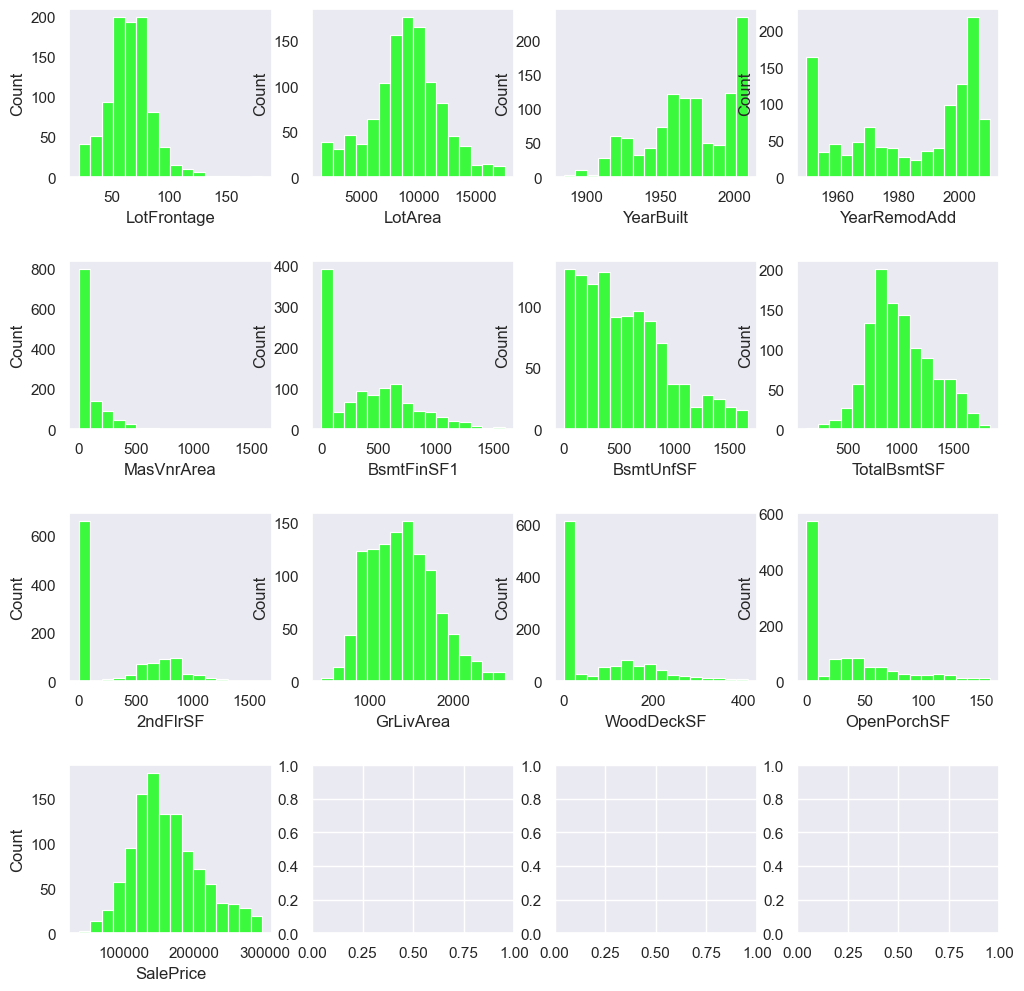

In [21]:
# исключаем столбцы с порядковыми данными
not_ord_columns = num_columns.drop(ORD_FEATURES, errors ="ignore")

show_hist(df, not_ord_columns, [])

Часть признаков не имеет нормального распределения. Кроме того, часть признаков имеет большое преобладание одного
значения (0). Ранее ( в работах №1 и №2) было показано, что логарифмирование таких признаков ухудшает качество
прогнозирования. В данном случае логарифмирование проводить не будем.

## 4.4. Исследовательский анализ данных

Создадим целевой признак - возраст (age), имеющий 2 значения: старый и новый. Исходный столбец с датой строительства
будет удален.

In [17]:
# df['age']=df.apply(lambda v: 'old' if v.YearBuilt<1950 else 'middle' if v.YearBuilt<2000 else 'new', axis =1)
df[TARGET_FEATURE]=df.apply(lambda v: 'old' if v.YearBuilt<1980 else 'new', axis =1)
cat_columns, num_columns = drop_feature(df, ['YearBuilt'], cat_columns,num_columns)

Удаляется признак YearBuilt


Оценим распределение значений целевой переменной.

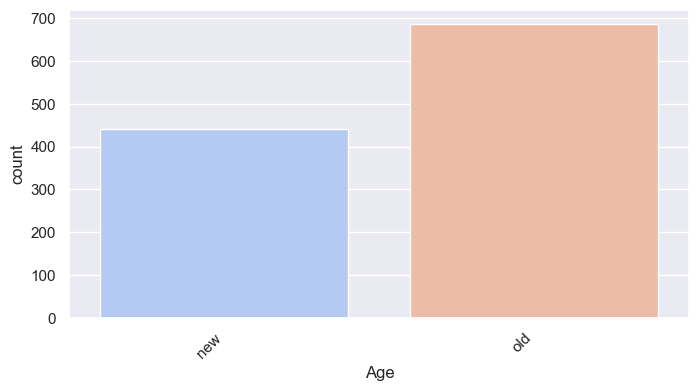

In [18]:
fig = plt.figure(figsize=(8, 4))
myplot=sns.countplot(df, x=TARGET_FEATURE, palette ='coolwarm');
myplot.set_xticklabels(myplot.get_xticklabels(), rotation=45,  horizontalalignment='right');

Целевой признак имеет 2 класса, представителей каждого класса достаточно, однако выборка не очень сбалансированная,
представителей класса old почти в 1,5 раза больше, чем представителей класса new.

Пустых значений в целевой переменной:

In [19]:
print(f"Размер набора данных: {len(df[TARGET_FEATURE])}")
print(f"Всего пропусков: {df[TARGET_FEATURE].isna().sum()}")

Размер набора данных: 1126
Всего пропусков: 0


Возможные значения целевого признака:

In [20]:
df[TARGET_FEATURE].value_counts()

Age
old    686
new    440
Name: count, dtype: int64

Закодируем значения целевого признака:

In [21]:
forw_mapping = {'new': 0, 'old': 1}
back_mapping = {0:'new', 1:'old' }
df.replace({TARGET_FEATURE: forw_mapping}, inplace=True)

Оценим волатильность категориальных признаков относительно целевого признака

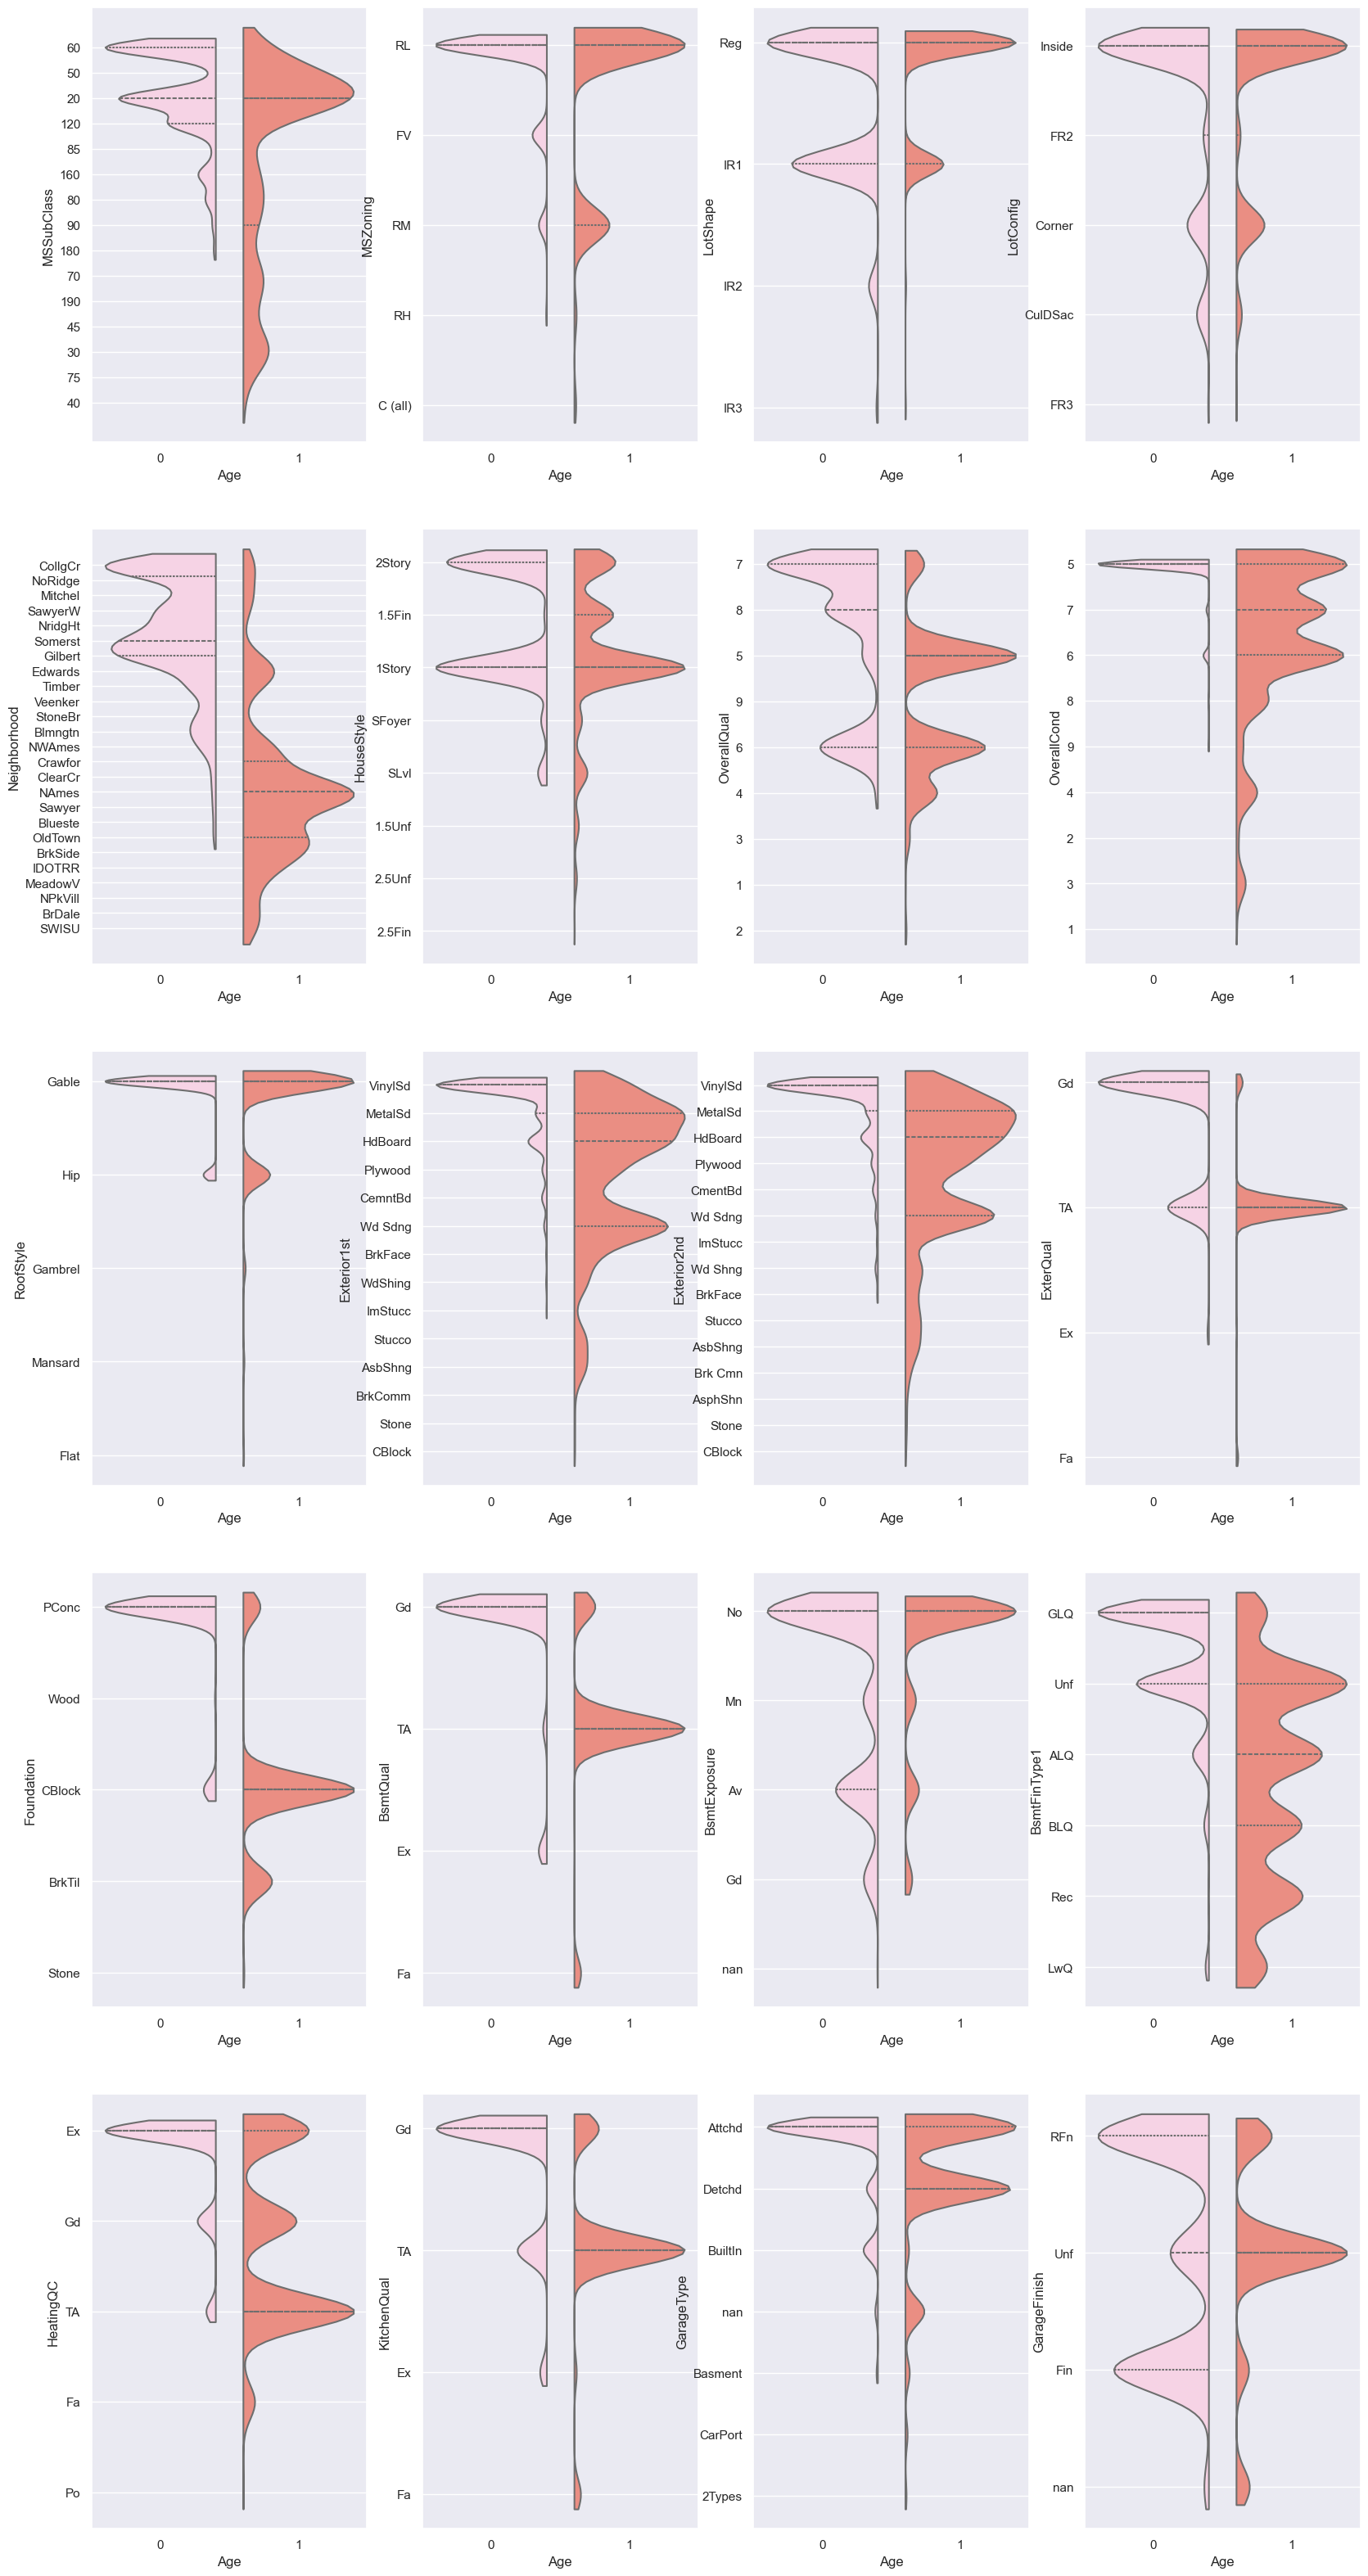

In [29]:
_cols = 4
_rows = int(np.ceil(len(cat_columns) / _cols))
fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(20, 40), gridspec_kw={'wspace':0.2,'hspace':0.2 })
ax = ax.flatten()

for idx, cat_col in enumerate(cat_columns):
    sns.violinplot(
        df,
        x=df[TARGET_FEATURE],
        y=df[cat_col].astype(str),
        ax=ax[idx],
        orient='v',
        split=True,
        inner = "quartile",
        palette="Set3_r", bw=.2, cut=1, linewidth=1.5,
    )

Удалим не особо полезные признаки:

In [22]:
cat_columns, num_columns = drop_feature(df, [ 'LotShape','RoofStyle','MSZoning', 'LotConfig', 'OverallCond', 'ExterQual'], cat_columns,num_columns)

Удаляется признак LotShape
Удаляется признак RoofStyle
Удаляется признак MSZoning
Удаляется признак LotConfig
Удаляется признак OverallCond
Удаляется признак ExterQual


Оценим распределение значений категориальных признаков

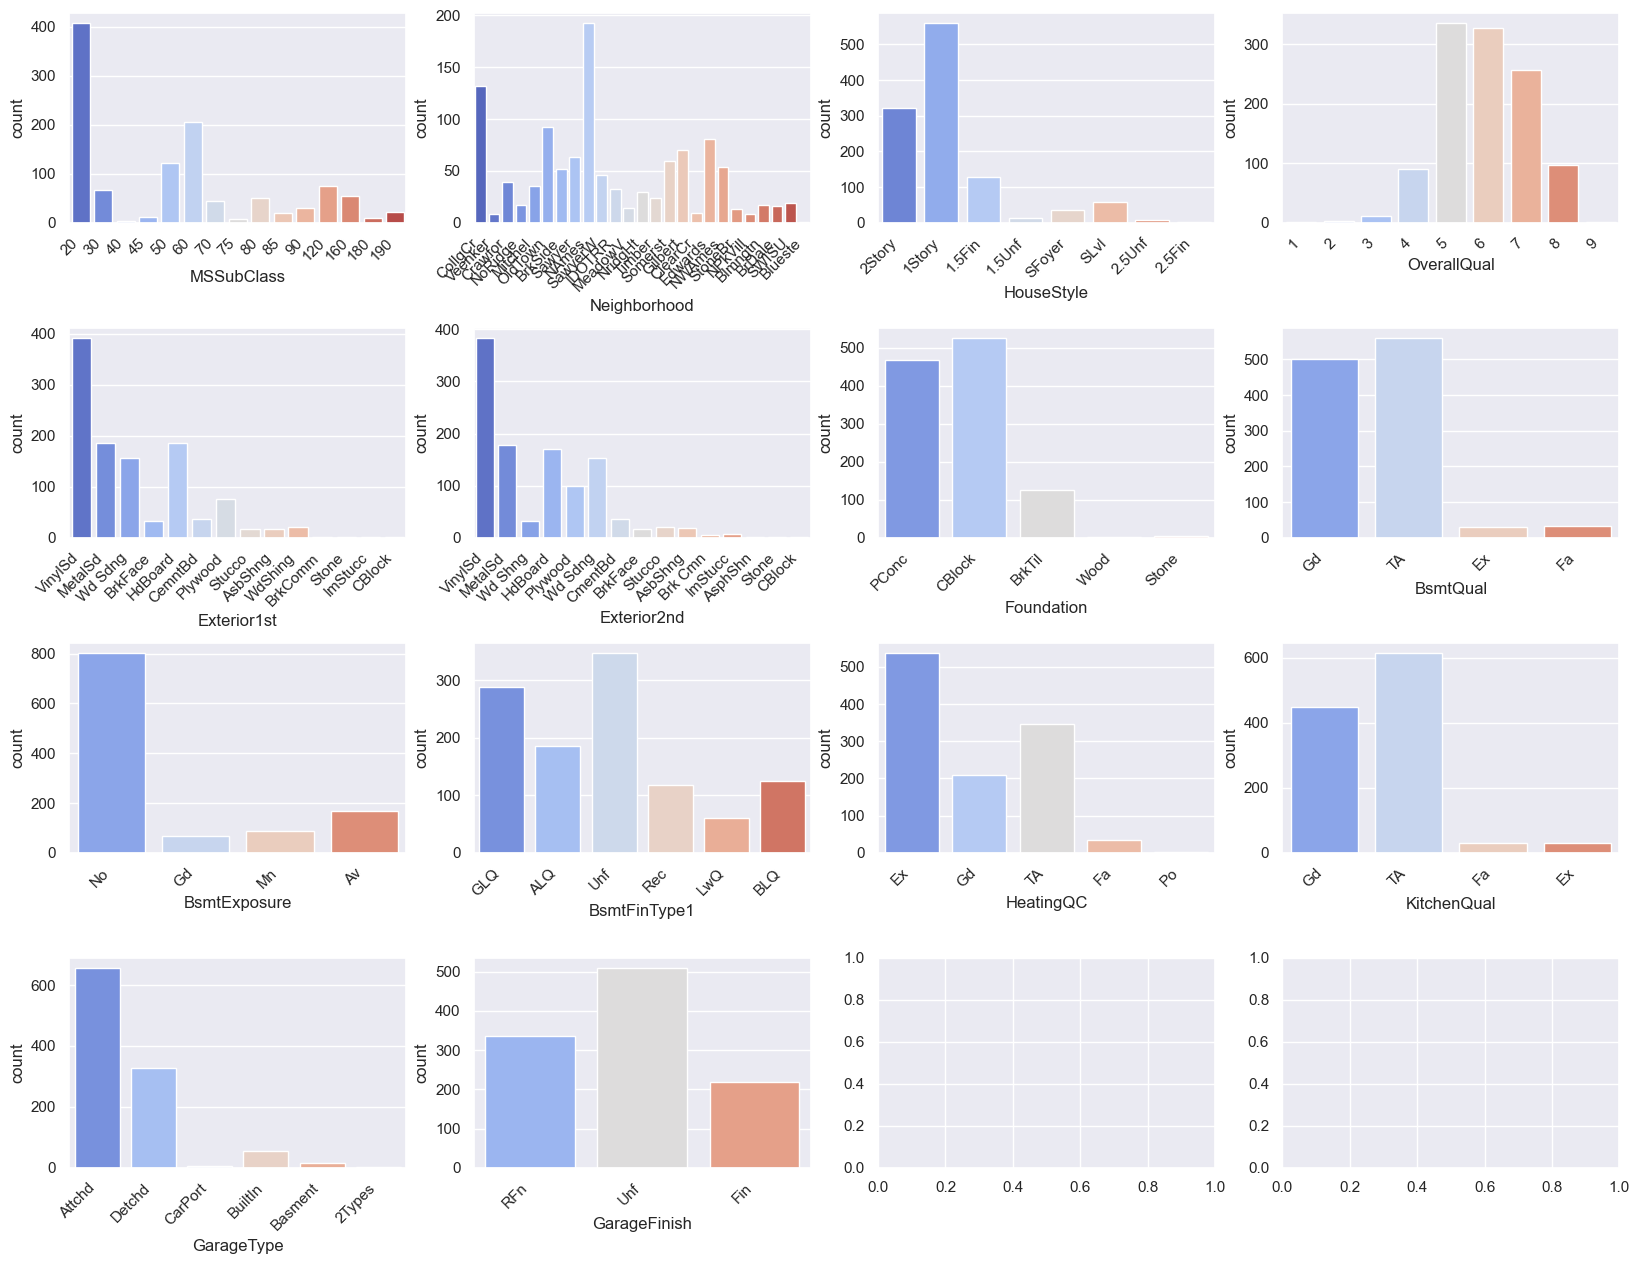

In [31]:
_cols = 4
_rows = int(np.ceil(len(cat_columns) / _cols))
fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(20, 15), gridspec_kw={'wspace':0.2,'hspace':0.5 })
ax = ax.flatten()

for idx, cat_col in enumerate(cat_columns):
    myplot=sns.countplot(df, x=cat_col, ax=ax[idx], palette ='coolwarm')
    myplot.set_xticklabels(myplot.get_xticklabels(), rotation=45,  horizontalalignment='right')

Распределение значений для признаков с порядковыми и интервальными  числовыми данными

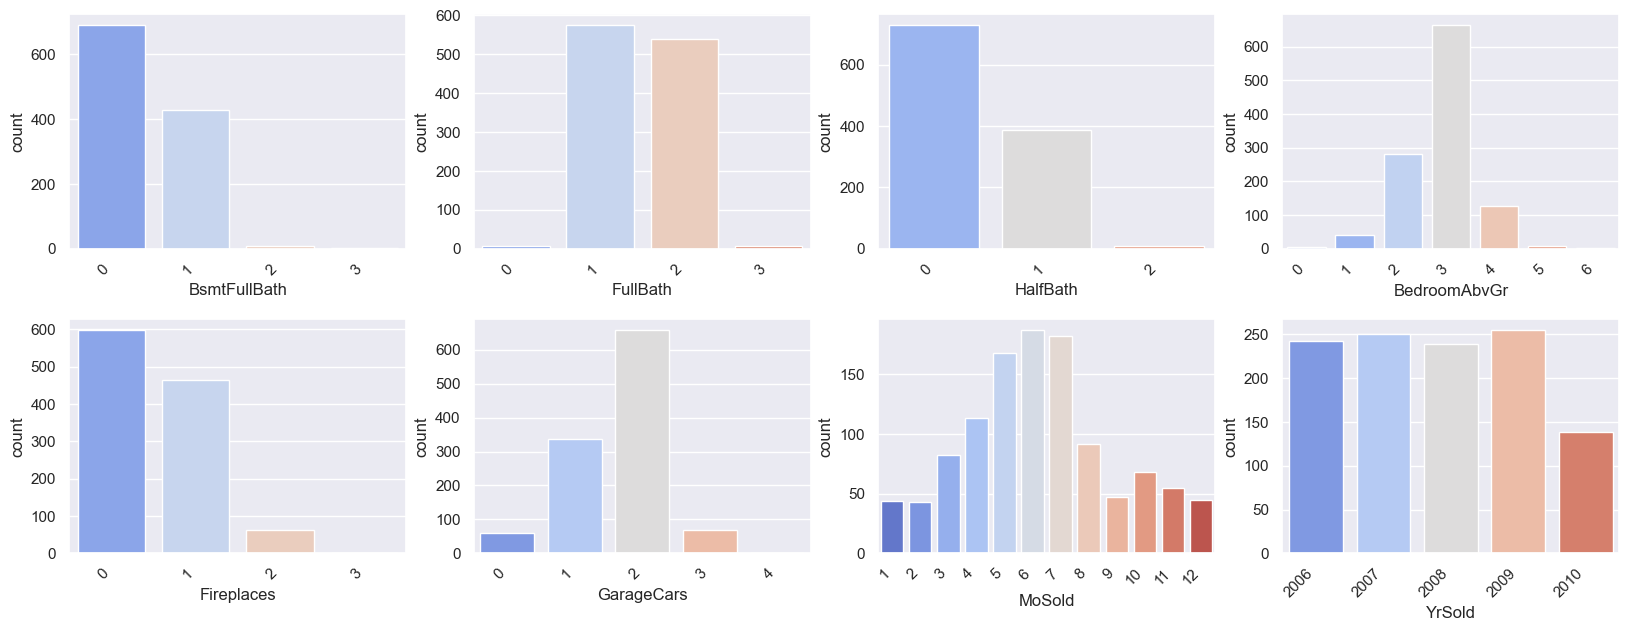

In [32]:
ord_columns_names =[col for col in df.columns if col in ORD_FEATURES and col in num_columns]
ord_columns=df[ord_columns_names].columns

_cols = 4
_rows = int(np.ceil(len(ord_columns) / _cols))
fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(20, 7), gridspec_kw={'wspace':0.2,'hspace':0.3 })
ax = ax.flatten()

for idx, cat_col in enumerate(ord_columns):
    myplot=sns.countplot(df, x=cat_col, ax=ax[idx], palette ='coolwarm')
    myplot.set_xticklabels(myplot.get_xticklabels(), rotation=45,  horizontalalignment='right')

Оценим волатильность порядковых признаков относительно целевого признака

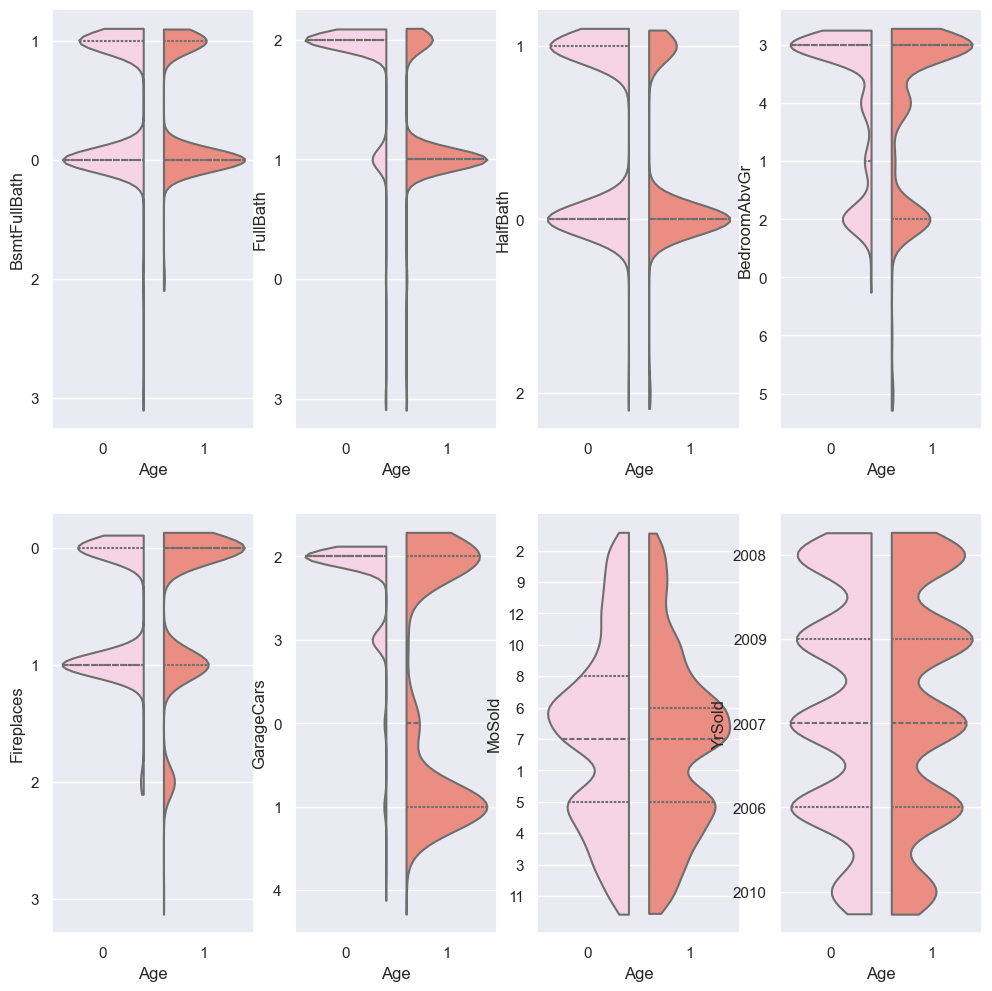

In [33]:
_cols = 4
_rows = int(np.ceil(len(ord_columns) / _cols))
fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(12, 12))
ax = ax.flatten()

for idx, cat_col in enumerate(ord_columns):
    sns.violinplot(
        df,
        x=df[TARGET_FEATURE],
        y=df[cat_col].astype(str),
        ax=ax[idx],
        orient='v',
        split=True,
        inner = "quartile",
        palette="Set3_r", bw=.2, cut=1, linewidth=1.5,
    )

Удалим не особо полезные признаки:

In [23]:
cat_columns, num_columns = drop_feature(df, [ 'BsmtFullBath','BedroomAbvGr', 'MoSold', 'YrSold'], cat_columns,
                                        num_columns)

Удаляется признак BsmtFullBath
Удаляется признак BedroomAbvGr
Удаляется признак MoSold
Удаляется признак YrSold


Все категориальные и порядковые признаки распределены неравномерно относительно разных ценовых категорий.

Посмотрим на взимосвязь категориальных и целевого признаков.

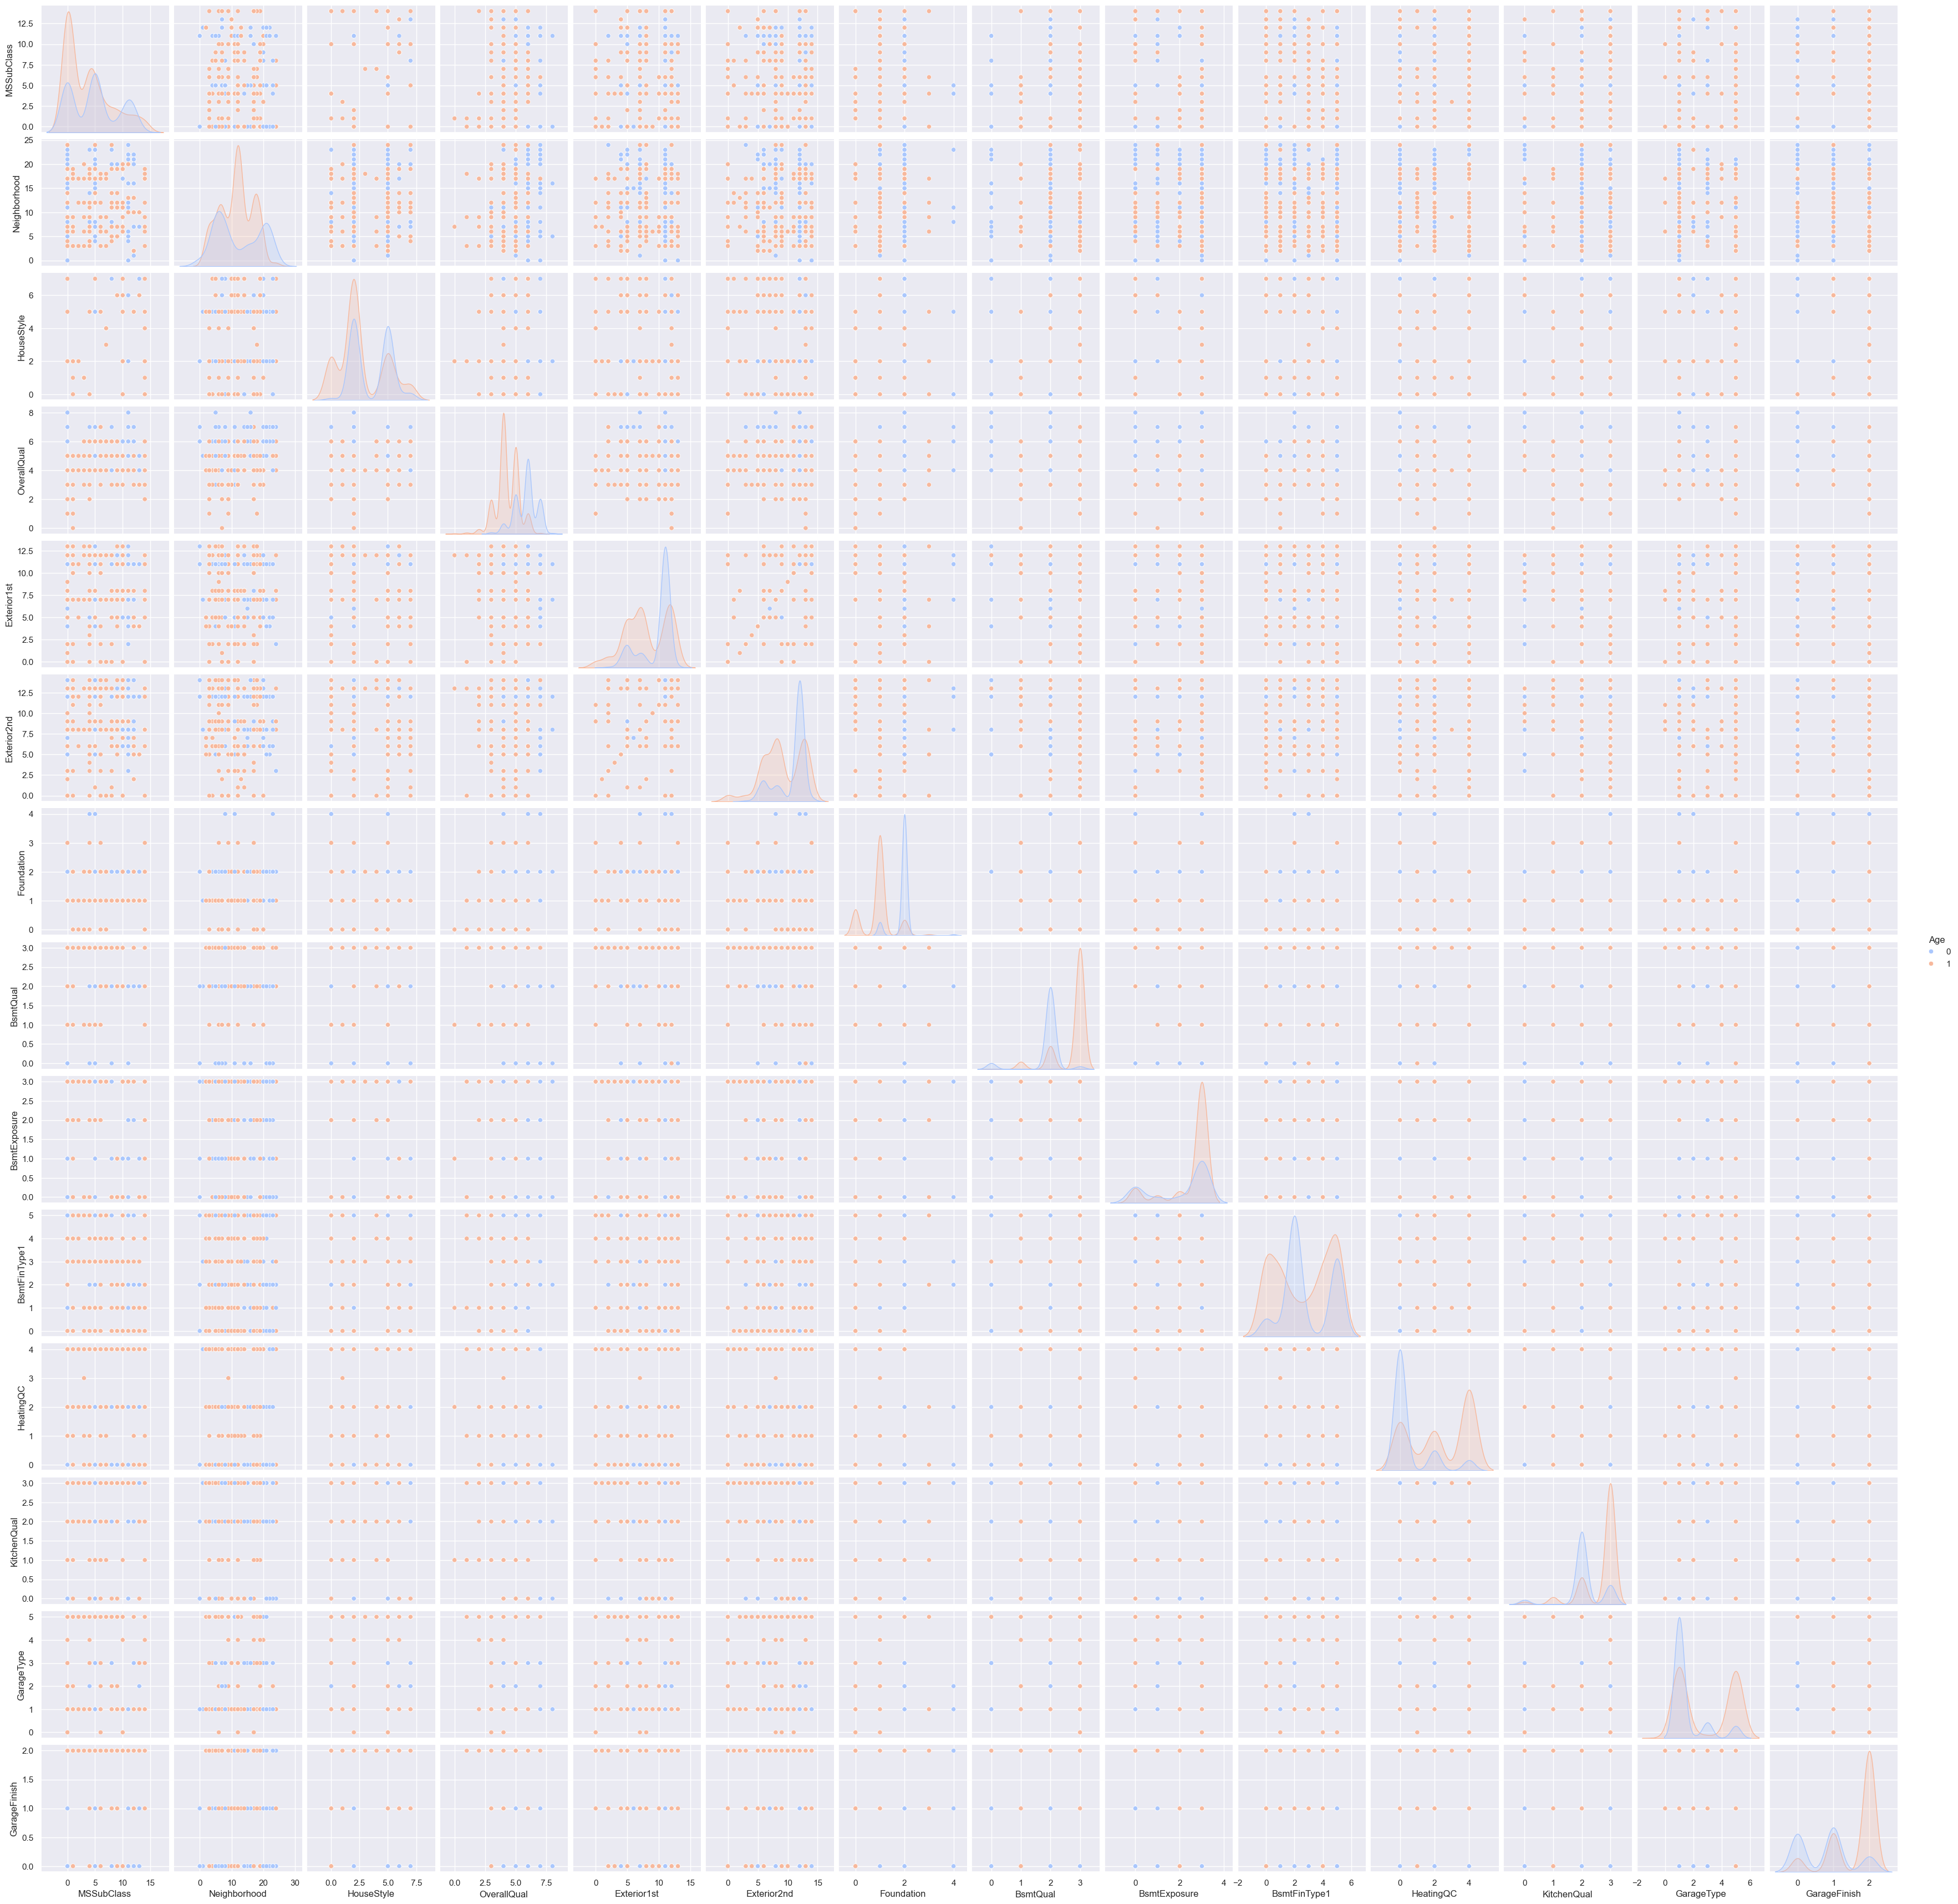

In [27]:
df1=df[cat_columns.append(pd.Index([TARGET_FEATURE]))]
enc = OrdinalEncoder()
df1[cat_columns]=enc.fit_transform(df1[cat_columns])
sns.pairplot(data = df1,  hue =TARGET_FEATURE,  palette = 'coolwarm')

На грфике видно, что отделить один кластер от другого будет достаточно сложно.

# 5. tSNE

Берем только числовые данные

In [28]:
X = df[num_columns].fillna(0).values
y = df[TARGET_FEATURE]

In [29]:
#@title Гиперпараметры tSNE {run: "auto" }
n_iter = 500 #@param {type:"slider", min:250, max:500, step:25}
perplexity = 50 #@param {type:"slider", min:5, max:50, step:5}

# создаем объект класса с указанием гиперпараметров
tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=perplexity,
            n_iter=n_iter, )

# обучаем и сразу трансформируем
# потому что это t-SNE и чисто "математически" нельзя отдельно fit и transform
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1126 samples in 0.000s...
[t-SNE] Computed neighbors for 1126 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1126
[t-SNE] Computed conditional probabilities for sample 1126 / 1126
[t-SNE] Mean sigma: 3231.966390
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.519180
[t-SNE] KL divergence after 500 iterations: 0.273564


Визуализируем результат

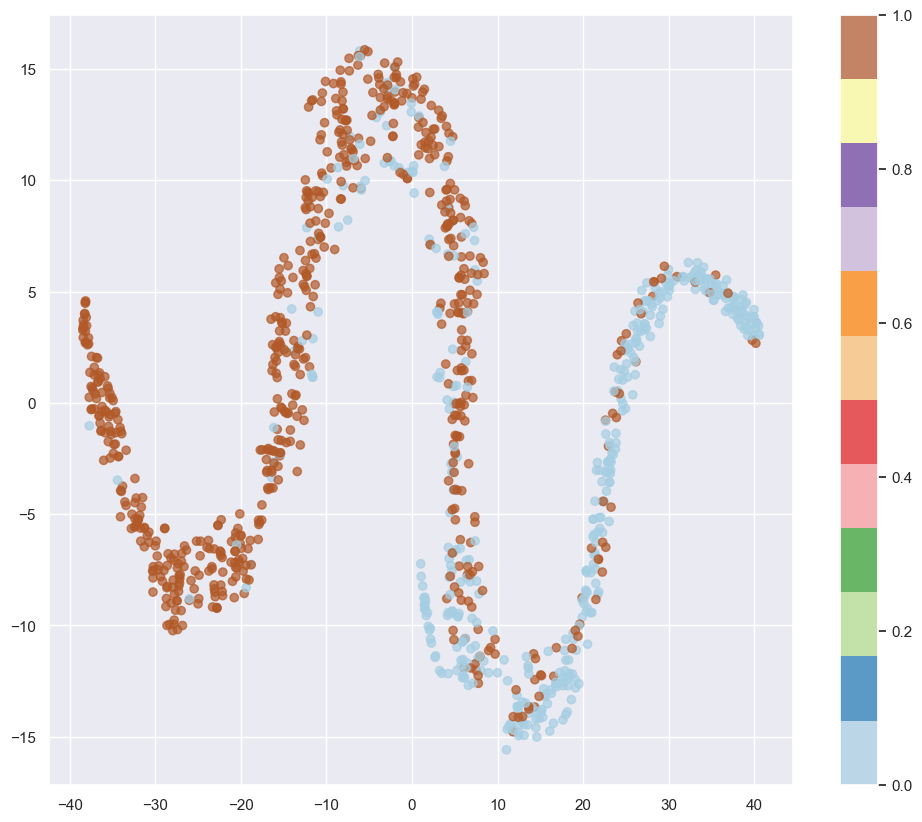

In [30]:
plt.figure(figsize=(12,10))
plt.scatter(
    tsne_results[:,0],
    tsne_results[:,1],
    c =df[TARGET_FEATURE].values, # подсцветим по типу отделки гаража
    alpha = 0.7,
    cmap ='Paired' ,)

plt.colorbar();

Визуально можно выделить отдельные скопления, соответствующие отдельным классам.

Пробуем другое значение Perplexity

In [53]:
#@title Гиперпараметры tSNE {run: "auto" }
n_iter = 500 #@param {type:"slider", min:250, max:500, step:25}
perplexity =5 #@param {type:"slider", min:5, max:50, step:5}

# создаем объект класса с указанием гиперпараметров
tsne2 = TSNE(n_components=2,
            verbose=1,
            perplexity=perplexity,
            n_iter=n_iter, )

# обучаем и сразу трансформируем
# потому что это t-SNE и чисто "математически" нельзя отдельно fit и transform
tsne_results2 = tsne2.fit_transform(X)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1126 samples in 0.001s...
[t-SNE] Computed neighbors for 1126 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1126
[t-SNE] Computed conditional probabilities for sample 1126 / 1126
[t-SNE] Mean sigma: 894.450192
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.842728
[t-SNE] KL divergence after 500 iterations: 0.654226


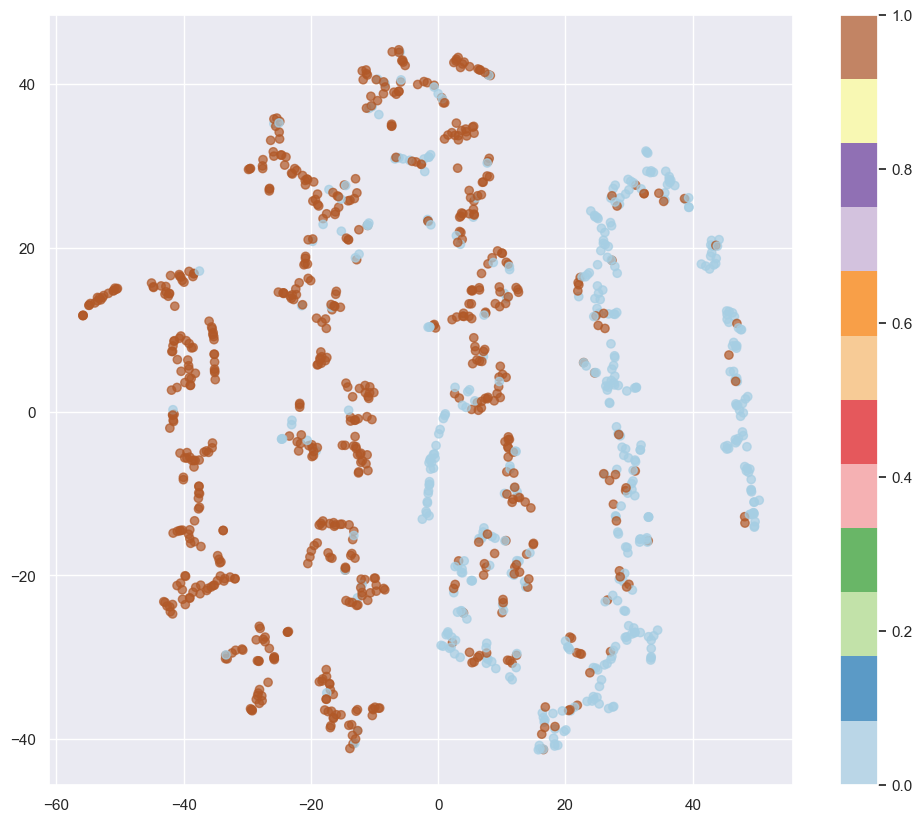

In [52]:
plt.figure(figsize=(12,10))
plt.scatter(
    tsne_results2[:,0],
    tsne_results2[:,1],
    c =df[TARGET_FEATURE].values, # подсцветим по типу отделки гаража
    alpha = 0.7,
    cmap ='Paired' ,)

plt.colorbar();

Результат изменился, граница между кластерами по-прежнему размыта. Первый вариант все же лучше будет.

# 6. Кластеризация

## 61. Разделение данных на тренировочную и валидационную выборку

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(TARGET_FEATURE, axis=1),
    df[TARGET_FEATURE],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

## 6.2. EM Кластеризация
Применяем GaussianMixture.

In [42]:
#Для числовых признаков
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
# Для категориальных признаков
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse=False))
])

column_pipeline = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_columns),
    ("cat", cat_pipeline, cat_columns)
])

model_pipeline = Pipeline([
    ("preprocessing", column_pipeline),
    ("model", GaussianMixture(n_components=2, covariance_type='full'))
])


In [43]:
model_pipeline.fit(X_train, y_train)

print("Тренировочная выборка")
classification_metrics(model_pipeline, X_train, y_train)

print("Тестовая выборка")
classification_metrics(model_pipeline, X_test, y_test)

Тренировочная выборка
f1_score:  0.7956852791878173
accuracy:  0.7956852791878173
precision:  0.7956852791878173
recall:  0.7956852791878173
Тестовая выборка
f1_score:  0.7899408284023669
accuracy:  0.7899408284023669
precision:  0.7899408284023669
recall:  0.7899408284023669


In [44]:
y_pred = model_pipeline.predict(X_test)
cross_tab = pd.crosstab(y_test, columns=[y_pred], rownames=["Метки"], colnames=["Предсказания"])
cross_tab

Предсказания    0    1
Метки                 
0             130   10
1              61  137

Результат не плохой. Но модель иногда ошибается.

## 6.3. Применим Kernel PCA

In [45]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("kpca", KernelPCA(n_components=8, kernel="sigmoid", degree=5, coef0=2.5, gamma=10))
])

# Для категориальных признаков
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse=False))
])

column_pipeline = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_columns),
    ("cat", cat_pipeline, cat_columns)
])

model_pipeline = Pipeline([
    ("preprocessing", column_pipeline),
    ("model", GaussianMixture(n_components=2, covariance_type='full'))
])

In [47]:
model_pipeline.fit(X_train, y_train)

print("Тренировочная выборка")
classification_metrics(model_pipeline, X_train, y_train)

print("Тестовая выборка")
classification_metrics(model_pipeline, X_test, y_test)

Тренировочная выборка
f1_score:  0.9086294416243654
accuracy:  0.9086294416243654
precision:  0.9086294416243654
recall:  0.9086294416243654
Тестовая выборка
f1_score:  0.9142011834319527
accuracy:  0.9142011834319527
precision:  0.9142011834319527
recall:  0.9142011834319527


In [48]:
y_pred = model_pipeline.predict(X_test)
cross_tab = pd.crosstab(y_test, columns=[y_pred], rownames=["Метки"], colnames=["Предсказания"])
cross_tab

Предсказания    0    1
Метки                 
0             132    8
1              21  177

Визуализация

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1126 samples in 0.001s...
[t-SNE] Computed neighbors for 1126 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1126
[t-SNE] Computed conditional probabilities for sample 1126 / 1126
[t-SNE] Mean sigma: 0.459827
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.687199
[t-SNE] KL divergence after 500 iterations: 0.923724


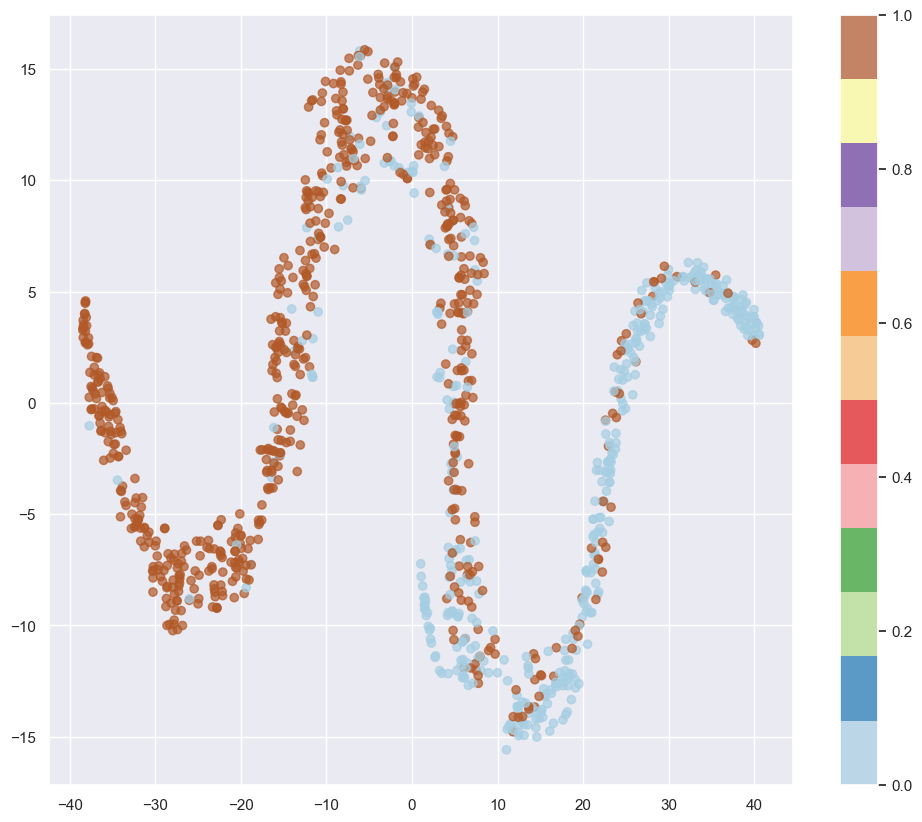

In [57]:
column_pipeline = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_columns)
])

model_pipeline = Pipeline([
    ("preprocessing", column_pipeline)
])

X = df[num_columns].fillna(0)
y = df[TARGET_FEATURE]

X_tr = model_pipeline.fit_transform(X)

tsne3 = TSNE(n_components=2,
            verbose=1,
            perplexity=50,
            n_iter=500, )

tsne_results3 = tsne3.fit_transform(X_tr)

plt.figure(figsize=(12,10))
plt.scatter(
    tsne_results[:,0],
    tsne_results[:,1],
    c =df[TARGET_FEATURE].values, # подсцветим по типу отделки гаража
    alpha = 0.7,
    cmap ='Paired' ,)

plt.colorbar();

## Выводы
1. Продвинутые методы кластеризации с вероятностным подходом могут быть достаточно эффективными при наличии сложных
несбалансированных данных.
2. РCA может значительно повысить качество кластеризации.